## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum Neural Networks-Parallel and Classical Convolutional Neural Networks on the MESSIDOR dataset. The MESSIDOR dataset is a diabetic-retinopathy dataset with 1544 fundus images. The dataset was produced in France and is labeled with five-category classification (no diabetic retinopathy, mild diabetic retinopathy, moderate diabetic retinopathy, severe diabetic retinopathy, and proliferative diabetic retinopathy).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.2 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import random
from itertools import cycle

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR_models_QNN-Parallel/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed, quantum=False):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


  model.load_state_dict(best_model_weights)

  if quantum:
    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  else:
    torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)

  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUROC: {auc_hybrid:.4f}')
        print(f'Normal Model AUROC: {auc_normal:.4f}')

        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



    filtered_normal_aucs = [auc for auc in normal_aucs if auc > 0]
    filtered_hybrid_aucs = [auc for auc in hybrid_aucs if auc > 0]
    print(filtered_normal_aucs)
    print(filtered_hybrid_aucs)

    # Calculate average AUC, handling cases where all values might be zero
    normal_auc = f"{sum(filtered_normal_aucs) / len(filtered_normal_aucs):.4f}" if filtered_normal_aucs else "N/A"
    hybrid_auc = f"{sum(filtered_hybrid_aucs) / len(filtered_hybrid_aucs):.4f}" if filtered_hybrid_aucs else "N/A"

    print("\nHybrid Model Metrics:")
    print(f'Accuracy: {accuracy_hybrid:.4f}')
    print(f'F1 Score: {f1_hybrid:.4f}')
    print(f'Precision: {precision_hybrid:.4f}')
    print(f'Recall: {recall_hybrid:.4f}')
    print(f'AUROC: {hybrid_auc}')

    print("\nNormal Model Metrics:")
    print(f'Accuracy: {accuracy_normal:.4f}')
    print(f'F1 Score: {f1_normal:.4f}')
    print(f'Precision: {precision_normal:.4f}')
    print(f'Recall: {recall_normal:.4f}')
    print(f'AUROC: {normal_auc} \n')

    cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    cm_normal = confusion_matrix(all_labels, all_preds_normal)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical CNN Model Construction

In [ ]:
class NormalModel(nn.Module):
    def __init__(self, num_classes):
        super(NormalModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Hybrid Quantum Neural Network Construction

In [ ]:
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define the QLayer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}


In [ ]:
class QuantumHybridModel(nn.Module):
    def __init__(self, num_classes):
      super(QuantumHybridModel, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
      self.bn1 = nn.BatchNorm2d(16)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
      self.bn2 = nn.BatchNorm2d(32)
      self.qlayer1 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer2 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer3 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer4 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.fc1 = nn.Linear(32 * 56 * 56, 120)
      self.fc2 = nn.Linear(120, 20)
      self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        # Pass the output to the quantum layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1)
        x_1 = self.qlayer1(x_1)
        x_2 = self.qlayer2(x_2)
        x_3 = self.qlayer3(x_3)
        x_4 = self.qlayer4(x_4)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        x = self.fc3(x)
        return x

# Experiments

In [ ]:
n_epochs = 100
num_classes = 5
batch_size = 32
dataset = "Messidor"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

## Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 27:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1932, Training Accuracy: 55.35%, Training AUROC: 0.5792
Validation Loss: 1.1402, Validation Accuracy: 58.54%, Validation AUROC: 0.5684
Epoch [2/100]
Training Loss: 1.1214, Training Accuracy: 58.54%, Training AUROC: 0.6163
Validation Loss: 1.1393, Validation Accuracy: 56.50%, Validation AUROC: 0.6037
Epoch [3/100]
Training Loss: 1.1070, Training Accuracy: 57.61%, Training AUROC: 0.6543
Validation Loss: 1.1832, Validation Accuracy: 56.10%, Validation AUROC: 0.6153
Epoch [4/100]
Training Loss: 1.1261, Training Accuracy: 57.20%, Training AUROC: 0.6277
Validation Loss: 1.3130, Validation Accuracy: 58.13%, Validation AUROC: 0.6061
Epoch [5/100]
Training Loss: 1.1686, Training Accuracy: 55.86%, Training AUROC: 0.6219
Validation Loss: 1.1819, Validation Accuracy: 55.69%, Validation AUROC: 0.5754
Epoch [6/100]
Training Loss: 1.0764, Training Accuracy: 57.72%, Training AUROC: 0.6690
Validation Loss: 1.1226, Validation Accuracy: 56.10%, Validation AUROC: 0.6090
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.5521, Training Accuracy: 25.51%, Training AUROC: 0.4947
Validation Loss: 1.5551, Validation Accuracy: 21.95%, Validation AUROC: 0.5350
Epoch [2/100]
Training Loss: 1.5486, Training Accuracy: 23.15%, Training AUROC: 0.5170
Validation Loss: 1.5646, Validation Accuracy: 7.32%, Validation AUROC: 0.5459
Epoch [3/100]
Training Loss: 1.5495, Training Accuracy: 19.65%, Training AUROC: 0.5212
Validation Loss: 1.5586, Validation Accuracy: 11.38%, Validation AUROC: 0.5156
Epoch [4/100]
Training Loss: 1.5511, Training Accuracy: 18.93%, Training AUROC: 0.4907
Validation Loss: 1.5414, Validation Accuracy: 34.15%, Validation AUROC: 0.5333
Epoch [5/100]
Training Loss: 1.5281, Training Accuracy: 32.10%, Training AUROC: 0.5244
Validation Loss: 1.5185, Validation Accuracy: 43.09%, Validation AUROC: 0.5258
Epoch [6/100]
Training Loss: 1.5120, Training Accuracy: 43.21%, Training AUROC: 0.5285
Validation Loss: 1.5138, Validation Accuracy: 43.90%, Validation AUROC: 0.4754
Epoch

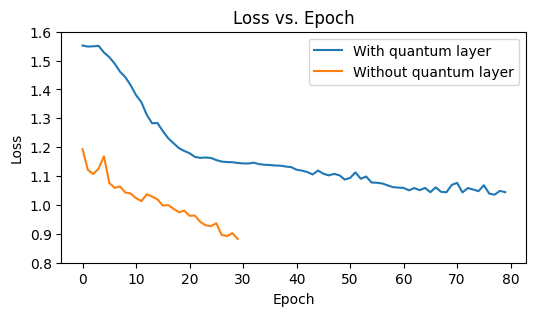

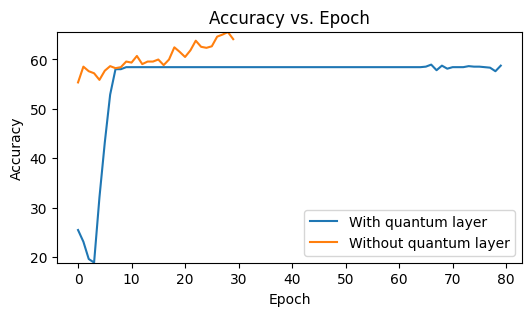

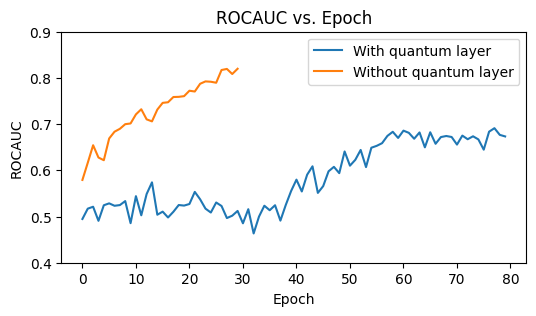

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

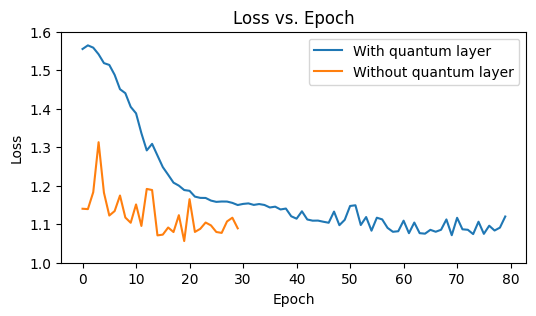

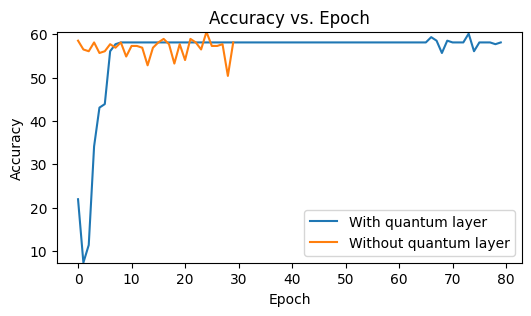

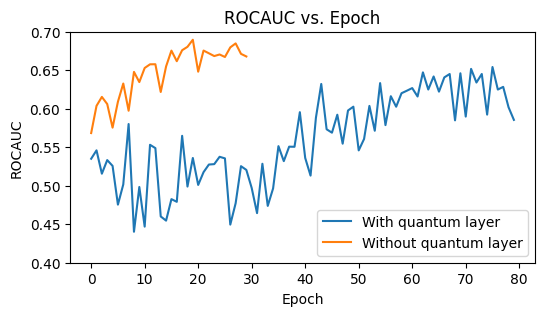

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


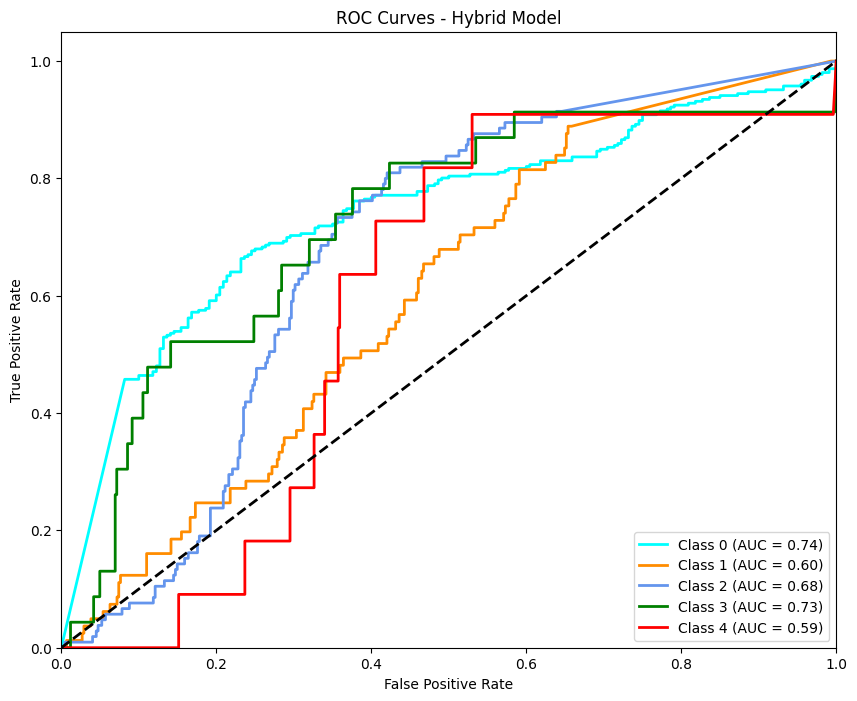

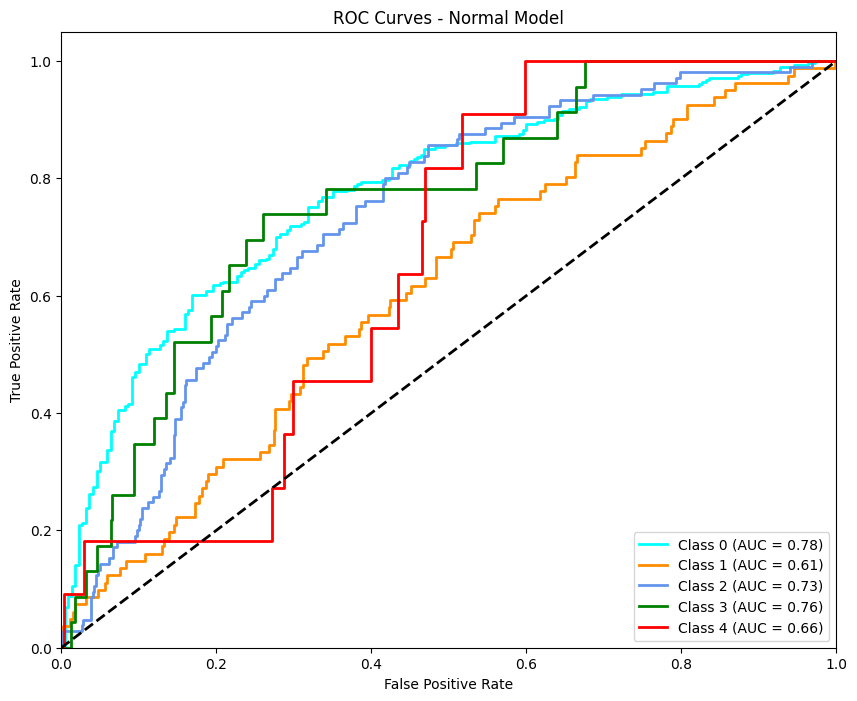

[0.7767528223410576, 0.6086835899569982, 0.7324510801945482, 0.7603941567983403, 0.6566637246248896]
[0.741131907308378, 0.6035095020113747, 0.6786223277909738, 0.7251274958942, 0.5938217122683143]

Hybrid Model Metrics:
Accuracy: 0.5817
F1 Score: 0.4279
Precision: 0.3384
Recall: 0.5817
AUROC: 0.6684

Normal Model Metrics:
Accuracy: 0.6141
F1 Score: 0.5427
Precision: 0.4866
Recall: 0.6141
AUROC: 0.7070 



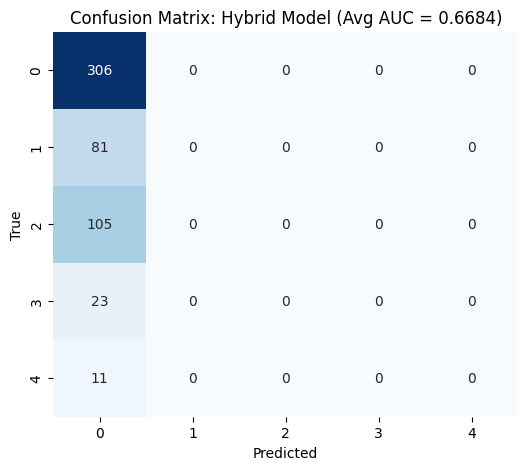

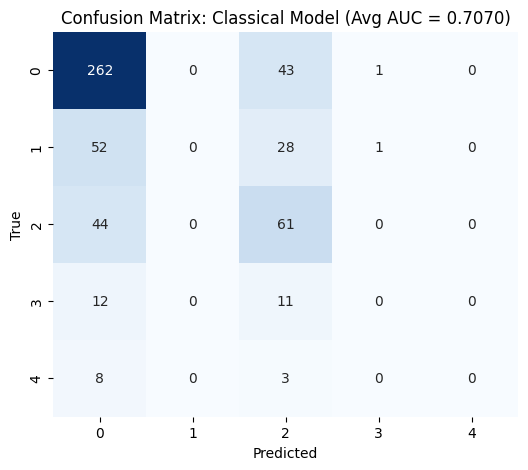

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 84:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1912, Training Accuracy: 57.10%, Training AUROC: 0.5586
Validation Loss: 1.1301, Validation Accuracy: 58.13%, Validation AUROC: 0.5752
Epoch [2/100]
Training Loss: 1.1293, Training Accuracy: 57.72%, Training AUROC: 0.5985
Validation Loss: 1.1698, Validation Accuracy: 56.91%, Validation AUROC: 0.6307
Epoch [3/100]
Training Loss: 1.0850, Training Accuracy: 58.33%, Training AUROC: 0.6393
Validation Loss: 1.1113, Validation Accuracy: 59.76%, Validation AUROC: 0.6694
Epoch [4/100]
Training Loss: 1.0564, Training Accuracy: 58.64%, Training AUROC: 0.6833
Validation Loss: 1.1103, Validation Accuracy: 58.94%, Validation AUROC: 0.6665
Epoch [5/100]
Training Loss: 1.0610, Training Accuracy: 58.13%, Training AUROC: 0.6917
Validation Loss: 1.1260, Validation Accuracy: 55.69%, Validation AUROC: 0.6371
Epoch [6/100]
Training Loss: 1.0819, Training Accuracy: 57.10%, Training AUROC: 0.6704
Validation Loss: 1.2087, Validation Accuracy: 48.37%, Validation AUROC: 0.5962
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.4406, Training Accuracy: 56.28%, Training AUROC: 0.5283
Validation Loss: 1.4327, Validation Accuracy: 58.13%, Validation AUROC: 0.4913
Epoch [2/100]
Training Loss: 1.4142, Training Accuracy: 58.44%, Training AUROC: 0.5508
Validation Loss: 1.4149, Validation Accuracy: 58.13%, Validation AUROC: 0.5166
Epoch [3/100]
Training Loss: 1.4023, Training Accuracy: 58.44%, Training AUROC: 0.5518
Validation Loss: 1.3971, Validation Accuracy: 58.13%, Validation AUROC: 0.5581
Epoch [4/100]
Training Loss: 1.4025, Training Accuracy: 58.44%, Training AUROC: 0.5137
Validation Loss: 1.3891, Validation Accuracy: 58.13%, Validation AUROC: 0.4912
Epoch [5/100]
Training Loss: 1.3733, Training Accuracy: 58.44%, Training AUROC: 0.5561
Validation Loss: 1.3675, Validation Accuracy: 58.13%, Validation AUROC: 0.5667
Epoch [6/100]
Training Loss: 1.3504, Training Accuracy: 58.44%, Training AUROC: 0.5784
Validation Loss: 1.3422, Validation Accuracy: 58.13%, Validation AUROC: 0.4351
Epoc

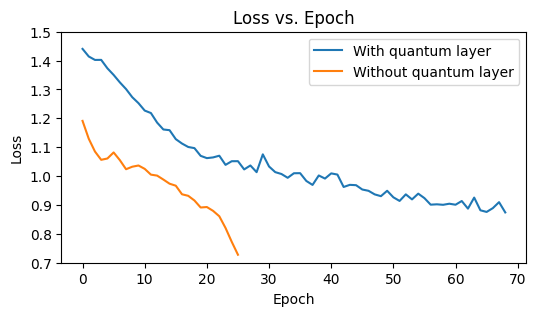

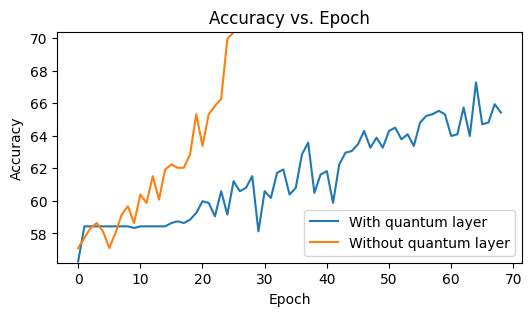

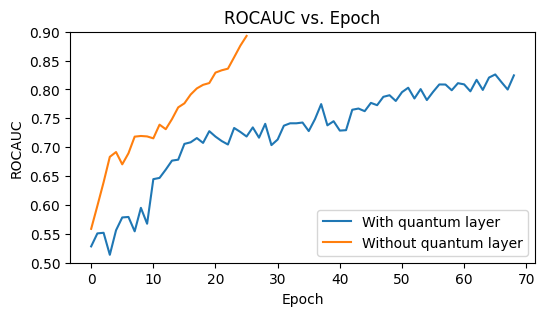

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

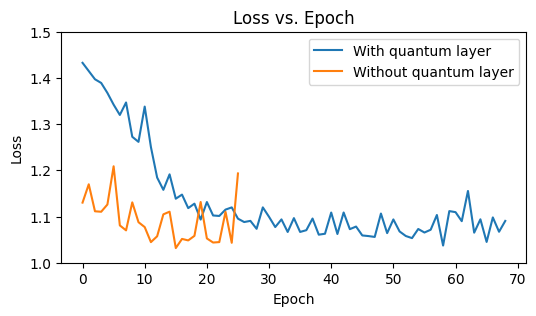

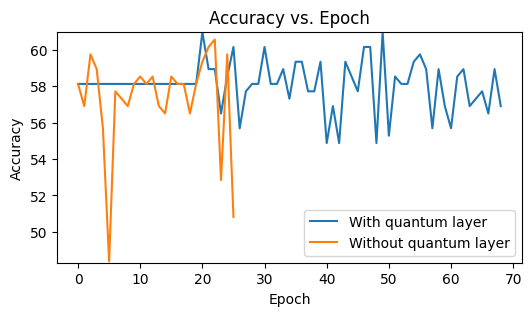

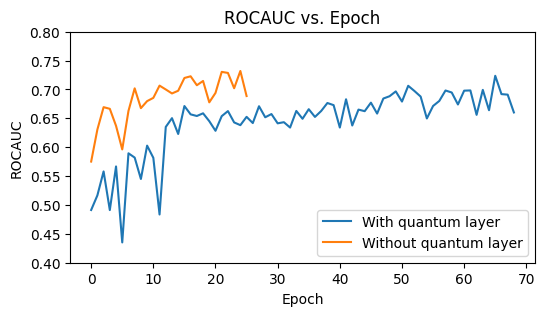

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


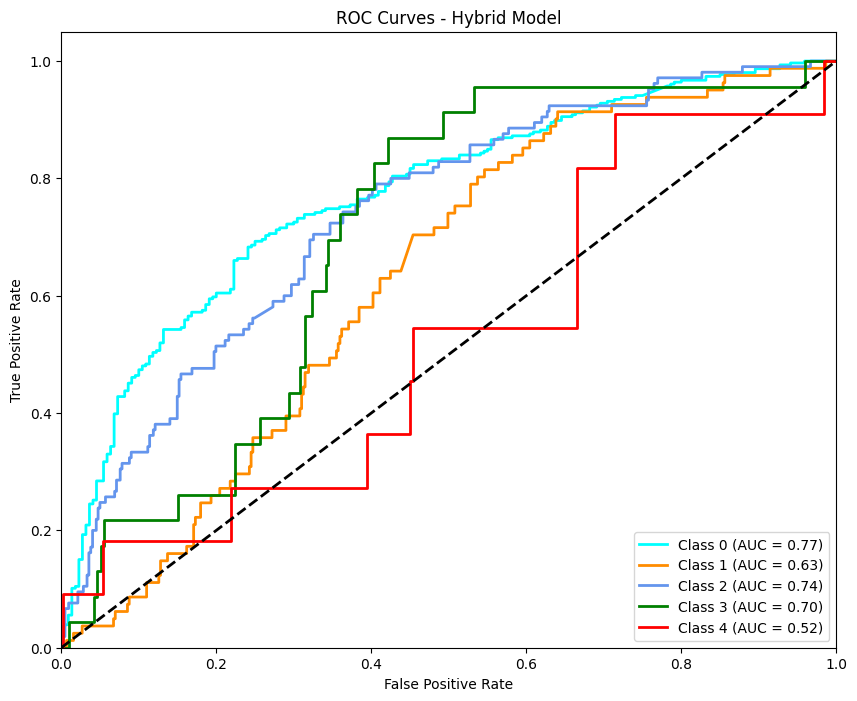

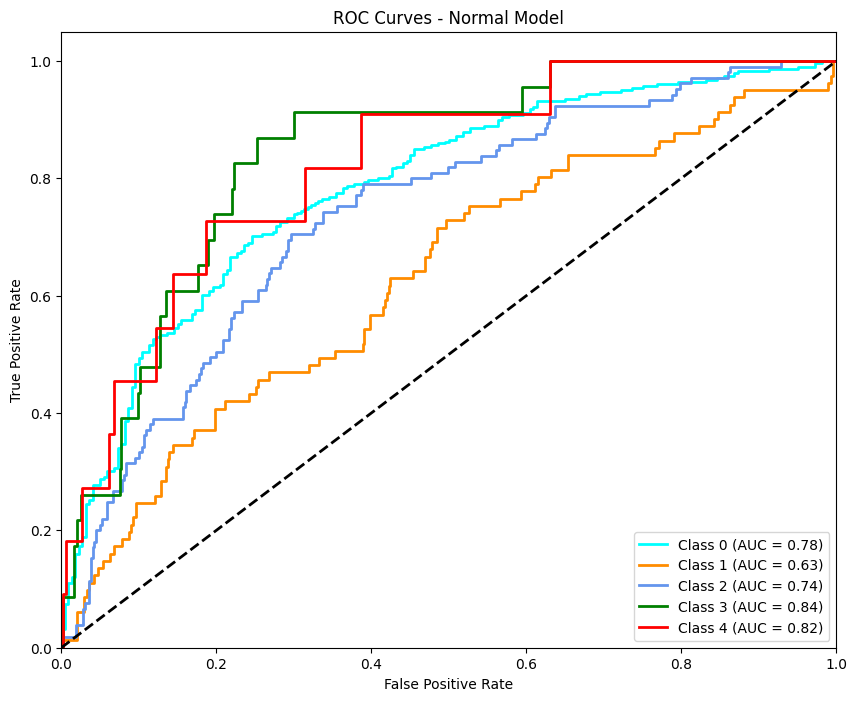

[0.7848039215686273, 0.6304341794978499, 0.7383327677864494, 0.8397441438326563, 0.8227714033539276]
[0.7715314913844324, 0.6289221806075738, 0.7387399615428119, 0.7019621402022648, 0.5207413945278023]

Hybrid Model Metrics:
Accuracy: 0.6084
F1 Score: 0.5235
Precision: 0.4646
Recall: 0.6084
AUROC: 0.6724

Normal Model Metrics:
Accuracy: 0.5970
F1 Score: 0.5592
Precision: 0.5756
Recall: 0.5970
AUROC: 0.7632 



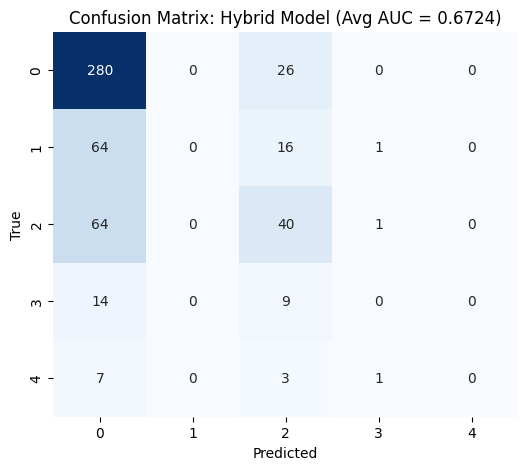

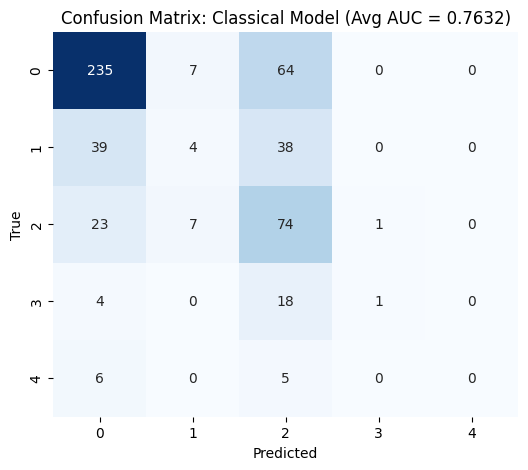

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

Experiment with Seed 94:


QuantumHybridModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (qlayer1): <Quantum Torch Layer: func=qnode>
  (qlayer2): <Quantum Torch Layer: func=qnode>
  (qlayer3): <Quantum Torch Layer: func=qnode>
  (qlayer4): <Quantum Torch Layer: func=qnode>
  (fc1): Linear(in_features=100352, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1646, Training Accuracy: 58.74%, Training AUROC: 0.5742
Validation Loss: 1.1079, Validation Accuracy: 57.32%, Validation AUROC: 0.6434
Epoch [2/100]
Training Loss: 1.1283, Training Accuracy: 56.58%, Training AUROC: 0.6114
Validation Loss: 1.1248, Validation Accuracy: 57.72%, Validation AUROC: 0.6463
Epoch [3/100]
Training Loss: 1.0918, Training Accuracy: 57.41%, Training AUROC: 0.6700
Validation Loss: 1.1979, Validation Accuracy: 58.13%, Validation AUROC: 0.6564
Epoch [4/100]
Training Loss: 1.1219, Training Accuracy: 56.17%, Training AUROC: 0.6342
Validation Loss: 1.1331, Validation Accuracy: 56.10%, Validation AUROC: 0.6159
Epoch [5/100]
Training Loss: 1.0512, Training Accuracy: 58.33%, Training AUROC: 0.7003
Validation Loss: 1.1236, Validation Accuracy: 59.35%, Validation AUROC: 0.6417
Epoch [6/100]
Training Loss: 1.0620, Training Accuracy: 59.77%, Training AUROC: 0.6829
Validation Loss: 1.3037, Validation Accuracy: 58.13%, Validation AUROC: 0.6433
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.5145, Training Accuracy: 34.36%, Training AUROC: 0.5036
Validation Loss: 1.4996, Validation Accuracy: 58.54%, Validation AUROC: 0.5045
Epoch [2/100]
Training Loss: 1.4531, Training Accuracy: 53.91%, Training AUROC: 0.5141
Validation Loss: 1.4362, Validation Accuracy: 56.91%, Validation AUROC: 0.4657
Epoch [3/100]
Training Loss: 1.4453, Training Accuracy: 54.12%, Training AUROC: 0.5225
Validation Loss: 1.4439, Validation Accuracy: 56.10%, Validation AUROC: 0.5520
Epoch [4/100]
Training Loss: 1.4318, Training Accuracy: 55.04%, Training AUROC: 0.5259
Validation Loss: 1.4228, Validation Accuracy: 58.13%, Validation AUROC: 0.6687
Epoch [5/100]
Training Loss: 1.4108, Training Accuracy: 58.74%, Training AUROC: 0.5524
Validation Loss: 1.4474, Validation Accuracy: 46.75%, Validation AUROC: 0.5898
Epoch [6/100]
Training Loss: 1.3867, Training Accuracy: 58.85%, Training AUROC: 0.5628
Validation Loss: 1.3853, Validation Accuracy: 58.54%, Validation AUROC: 0.6509
Epoc

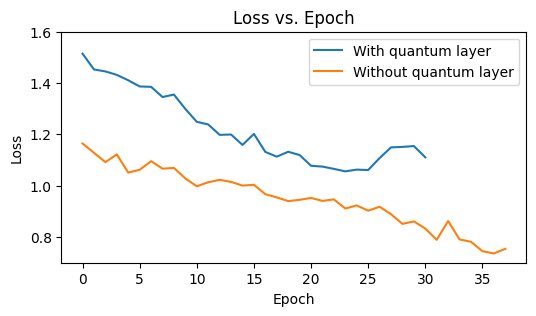

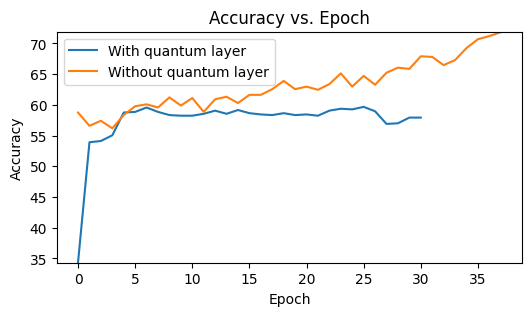

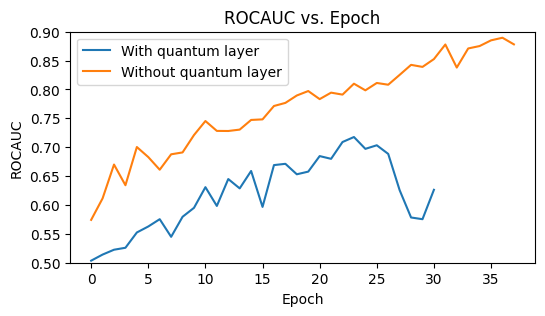

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

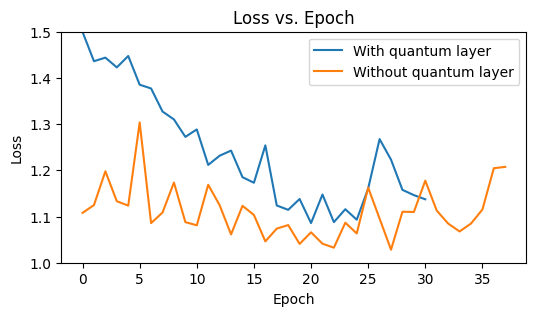

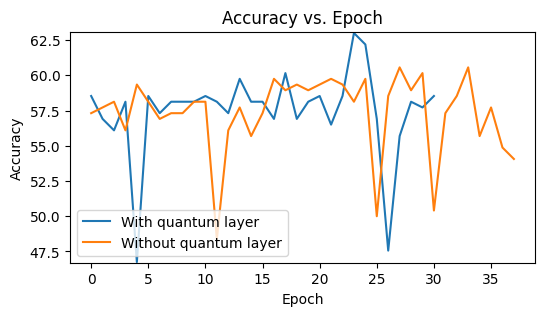

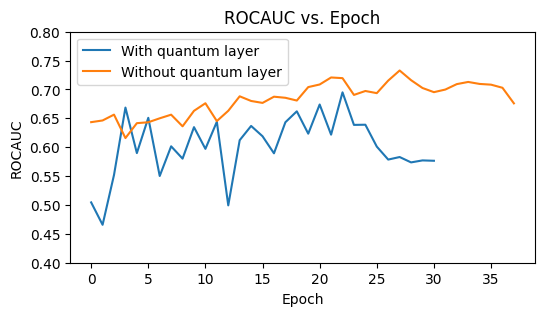

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


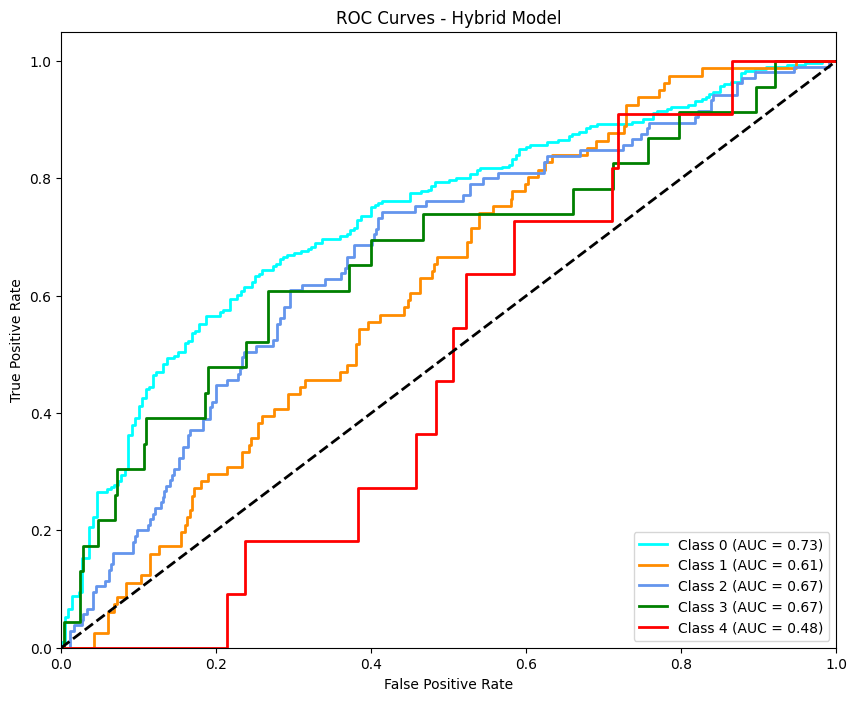

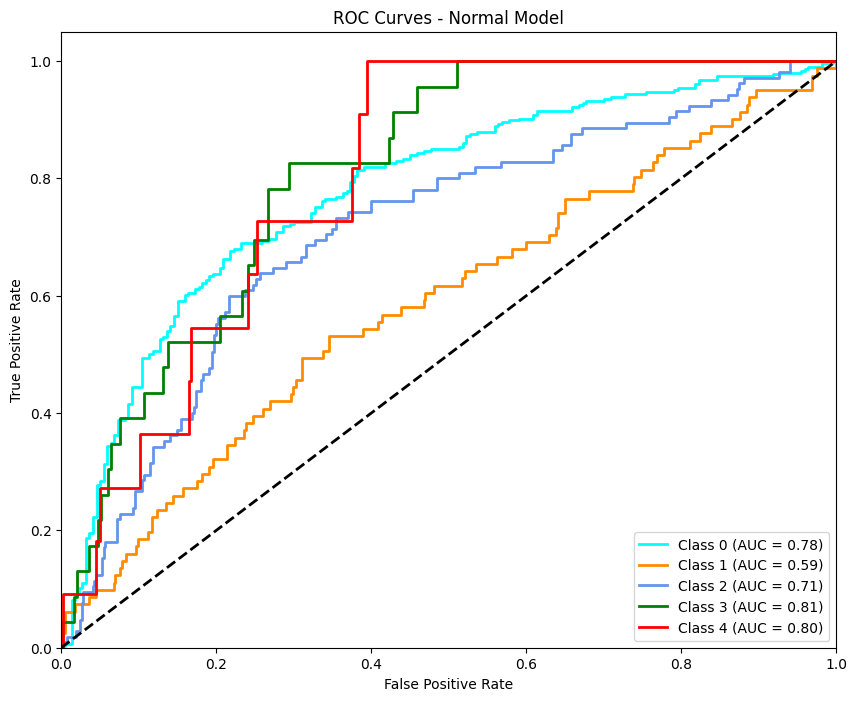

[0.7796345811051693, 0.5883756415591621, 0.7114579798665309, 0.8121704555277034, 0.8021182700794351]
[0.7349376114081997, 0.6148148148148148, 0.6723673792557403, 0.6690293024461924, 0.48349514563106794]

Hybrid Model Metrics:
Accuracy: 0.5837
F1 Score: 0.4444
Precision: 0.4013
Recall: 0.5837
AUROC: 0.6349

Normal Model Metrics:
Accuracy: 0.5989
F1 Score: 0.5655
Precision: 0.5571
Recall: 0.5989
AUROC: 0.7388 



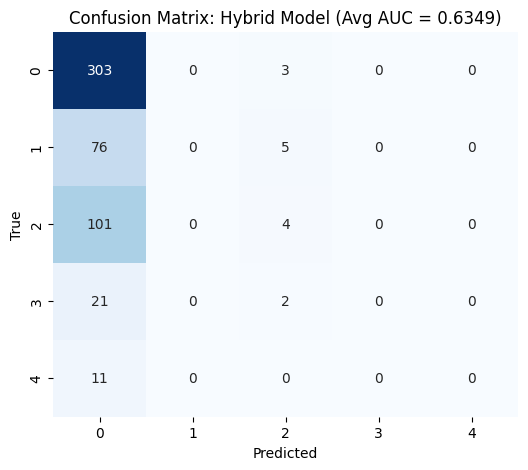

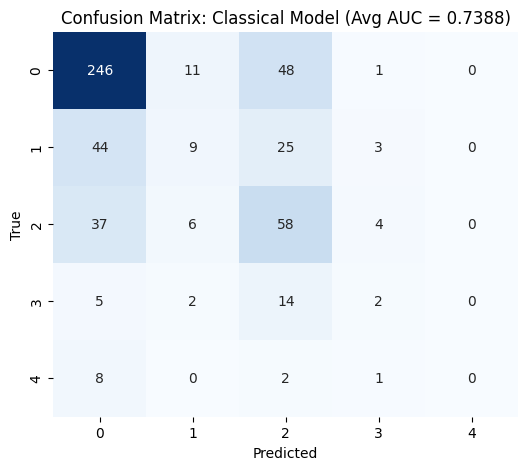

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1990, Training Accuracy: 54.63%, Training AUROC: 0.5346
Validation Loss: 1.2073, Validation Accuracy: 57.32%, Validation AUROC: 0.5727
Epoch [2/100]
Training Loss: 1.1082, Training Accuracy: 59.05%, Training AUROC: 0.6145
Validation Loss: 1.1015, Validation Accuracy: 58.54%, Validation AUROC: 0.6135
Epoch [3/100]
Training Loss: 1.0797, Training Accuracy: 58.33%, Training AUROC: 0.6651
Validation Loss: 1.1454, Validation Accuracy: 58.13%, Validation AUROC: 0.6118
Epoch [4/100]
Training Loss: 1.0571, Training Accuracy: 58.85%, Training AUROC: 0.6922
Validation Loss: 1.1276, Validation Accuracy: 53.25%, Validation AUROC: 0.6360
Epoch [5/100]
Training Loss: 1.0328, Training Accuracy: 57.82%, Training AUROC: 0.7010
Validation Loss: 1.1725, Validation Accuracy: 52.03%, Validation AUROC: 0.6337
Epoch [6/100]
Training Loss: 1.0707, Training Accuracy: 58.23%, Training AUROC: 0.7023
Validation Loss: 1.4112, Validation Accuracy: 35.37%, Validation AUROC: 0.6220
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.6024, Training Accuracy: 22.94%, Training AUROC: 0.5253
Validation Loss: 1.5869, Validation Accuracy: 29.27%, Validation AUROC: 0.4766
Epoch [2/100]
Training Loss: 1.6018, Training Accuracy: 23.15%, Training AUROC: 0.4879
Validation Loss: 1.6020, Validation Accuracy: 22.76%, Validation AUROC: 0.4839
Epoch [3/100]
Training Loss: 1.5991, Training Accuracy: 23.15%, Training AUROC: 0.4723
Validation Loss: 1.5821, Validation Accuracy: 19.92%, Validation AUROC: 0.5138
Epoch [4/100]
Training Loss: 1.5947, Training Accuracy: 19.55%, Training AUROC: 0.5077
Validation Loss: 1.6480, Validation Accuracy: 12.20%, Validation AUROC: 0.4649
Epoch [5/100]
Training Loss: 1.5970, Training Accuracy: 19.86%, Training AUROC: 0.4781
Validation Loss: 1.5754, Validation Accuracy: 19.11%, Validation AUROC: 0.5396
Epoch [6/100]
Training Loss: 1.5785, Training Accuracy: 20.47%, Training AUROC: 0.4920
Validation Loss: 1.5704, Validation Accuracy: 19.92%, Validation AUROC: 0.5160
Epoc

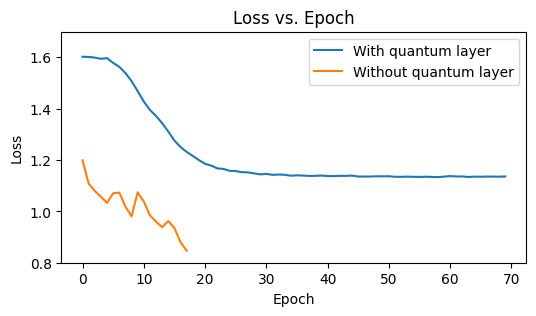

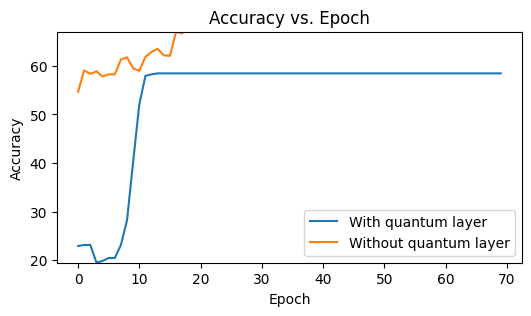

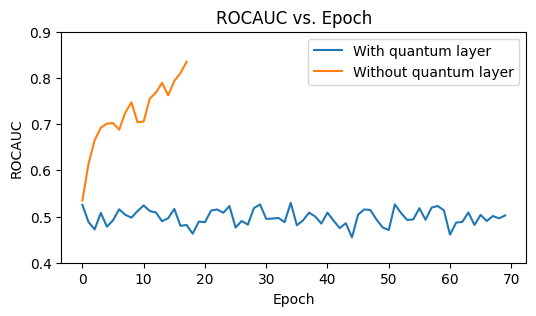

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

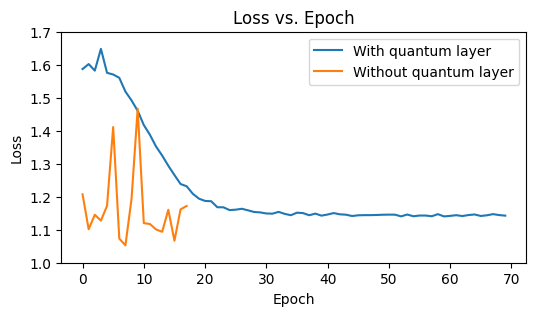

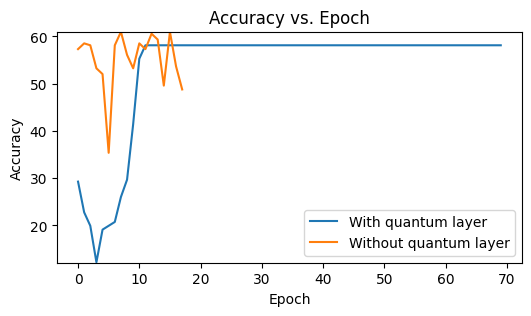

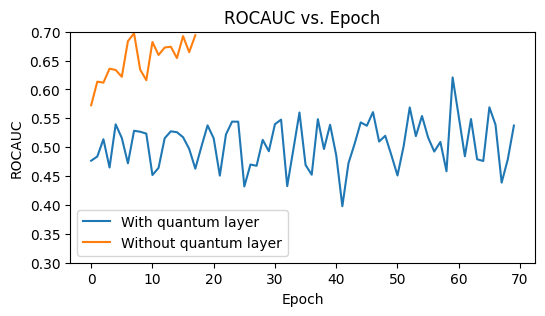

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


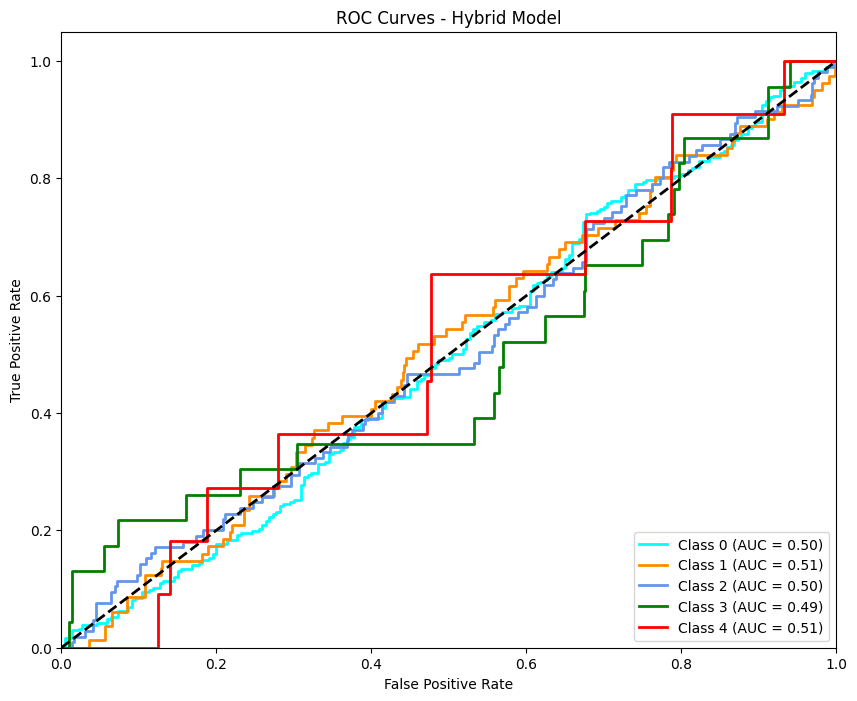

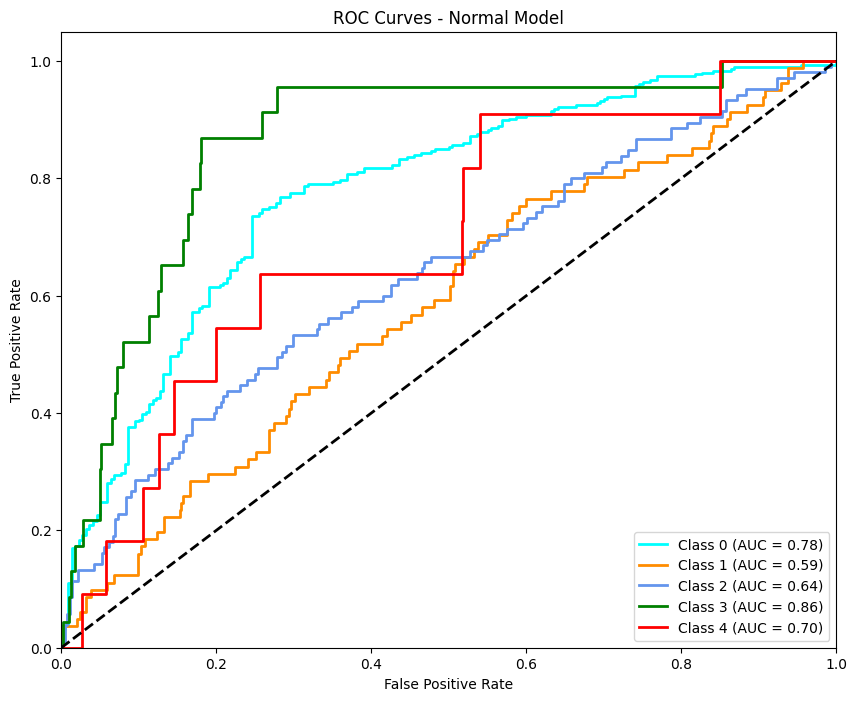

[0.779931669637552, 0.585129698987377, 0.6370772537043321, 0.8646382574120495, 0.6960282436010591]
[0.49558823529411766, 0.507143847967818, 0.5020246578441352, 0.4889791684674561, 0.5143865842894969]

Hybrid Model Metrics:
Accuracy: 0.5817
F1 Score: 0.4279
Precision: 0.3384
Recall: 0.5817
AUROC: 0.5016

Normal Model Metrics:
Accuracy: 0.5475
F1 Score: 0.5568
Precision: 0.5837
Recall: 0.5475
AUROC: 0.7126 



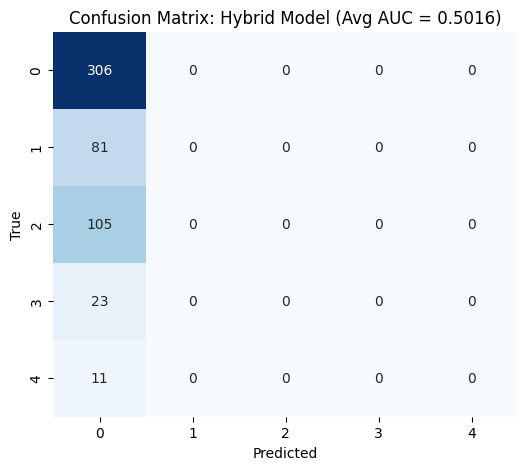

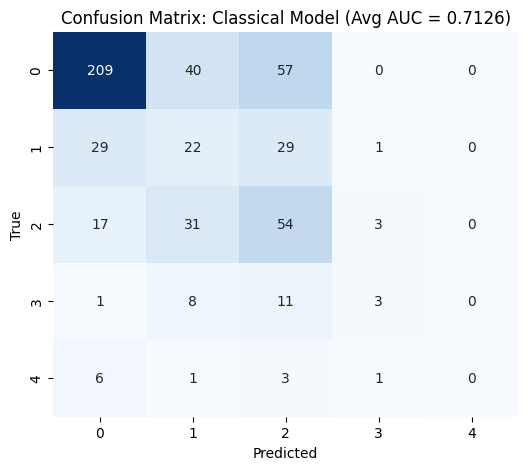

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(num_classes=5)
hybrid_model = QuantumHybridModel(num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
model.to(device)
hybrid_model.to(device)

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1863, Training Accuracy: 57.10%, Training AUROC: 0.5260
Validation Loss: 1.2451, Validation Accuracy: 51.22%, Validation AUROC: 0.5319
Epoch [2/100]
Training Loss: 1.1462, Training Accuracy: 57.00%, Training AUROC: 0.6016
Validation Loss: 1.1516, Validation Accuracy: 57.32%, Validation AUROC: 0.6262
Epoch [3/100]
Training Loss: 1.1193, Training Accuracy: 56.79%, Training AUROC: 0.6300
Validation Loss: 1.1299, Validation Accuracy: 57.32%, Validation AUROC: 0.6626
Epoch [4/100]
Training Loss: 1.0597, Training Accuracy: 58.02%, Training AUROC: 0.6875
Validation Loss: 1.1042, Validation Accuracy: 54.88%, Validation AUROC: 0.6656
Epoch [5/100]
Training Loss: 1.0883, Training Accuracy: 58.33%, Training AUROC: 0.6947
Validation Loss: 1.1232, Validation Accuracy: 55.69%, Validation AUROC: 0.6486
Epoch [6/100]
Training Loss: 1.0369, Training Accuracy: 59.57%, Training AUROC: 0.7140
Validation Loss: 1.0905, Validation Accuracy: 55.28%, Validation AUROC: 0.6761
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed,
    quantum=True
)

Epoch [1/100]
Training Loss: 1.5507, Training Accuracy: 53.40%, Training AUROC: 0.4983
Validation Loss: 1.5390, Validation Accuracy: 58.13%, Validation AUROC: 0.5351
Epoch [2/100]
Training Loss: 1.5438, Training Accuracy: 58.33%, Training AUROC: 0.5198
Validation Loss: 1.5181, Validation Accuracy: 58.13%, Validation AUROC: 0.4653
Epoch [3/100]
Training Loss: 1.4753, Training Accuracy: 57.82%, Training AUROC: 0.5077
Validation Loss: 1.4430, Validation Accuracy: 58.13%, Validation AUROC: 0.5724
Epoch [4/100]
Training Loss: 1.4363, Training Accuracy: 58.44%, Training AUROC: 0.5363
Validation Loss: 1.4229, Validation Accuracy: 58.13%, Validation AUROC: 0.4775
Epoch [5/100]
Training Loss: 1.4121, Training Accuracy: 58.44%, Training AUROC: 0.5301
Validation Loss: 1.4034, Validation Accuracy: 58.13%, Validation AUROC: 0.5228
Epoch [6/100]
Training Loss: 1.3821, Training Accuracy: 58.44%, Training AUROC: 0.5620
Validation Loss: 1.3787, Validation Accuracy: 58.13%, Validation AUROC: 0.6242
Epoc

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

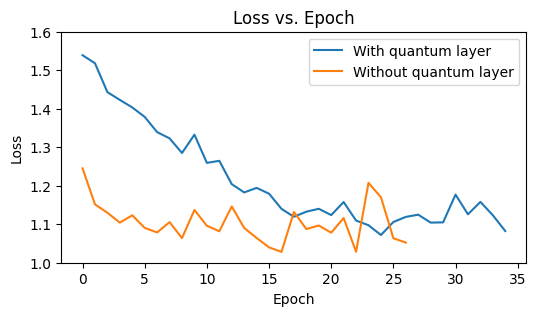

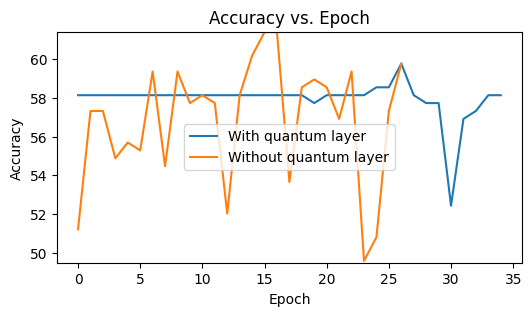

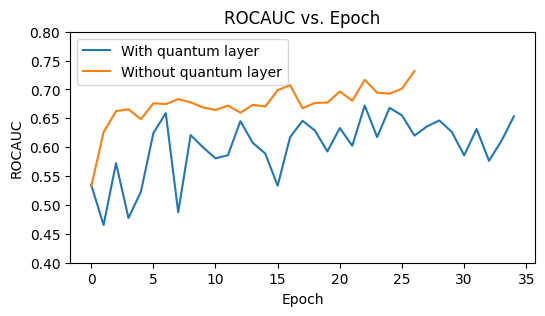

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


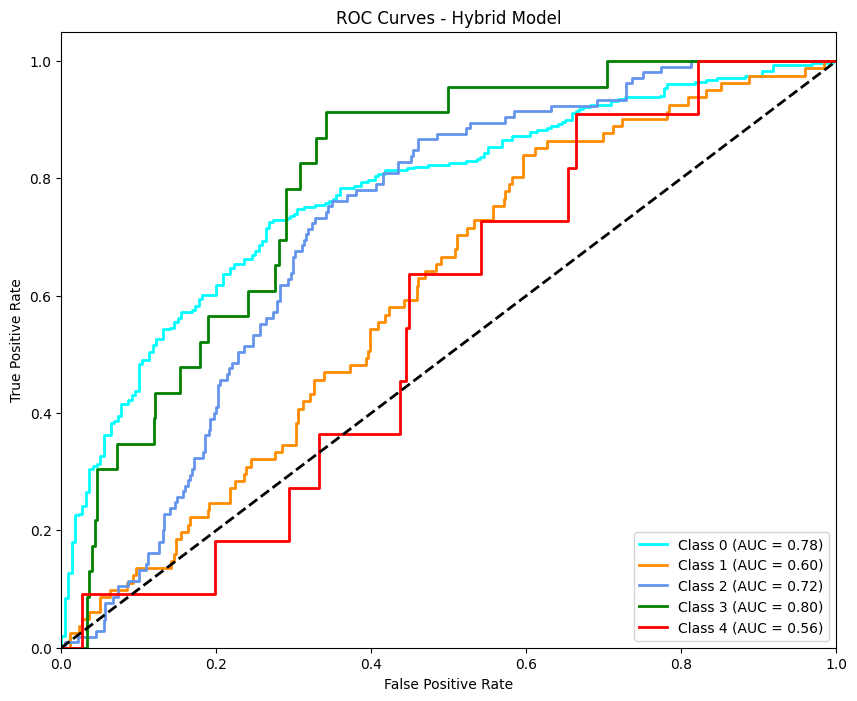

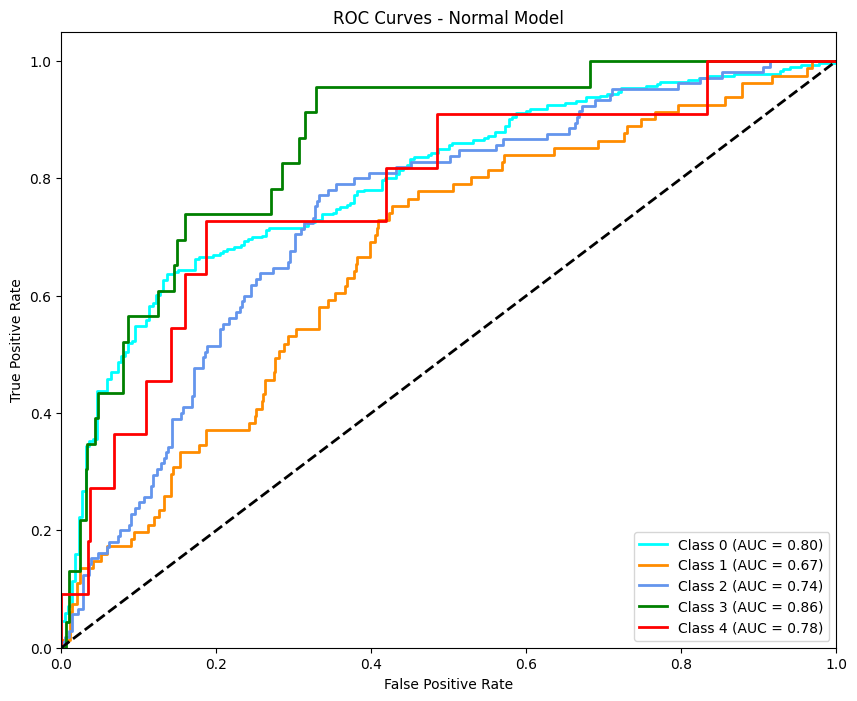

[0.7964795008912655, 0.667277014842558, 0.7384232552878633, 0.857809663756591, 0.7751103265666373]
[0.7769607843137255, 0.6049382716049383, 0.7200769143762018, 0.7969573861180742, 0.5579876434245367]

Hybrid Model Metrics:
Accuracy: 0.5894
F1 Score: 0.4938
Precision: 0.4389
Recall: 0.5894
AUROC: 0.6914

Normal Model Metrics:
Accuracy: 0.6027
F1 Score: 0.5381
Precision: 0.5090
Recall: 0.6027
AUROC: 0.7670 



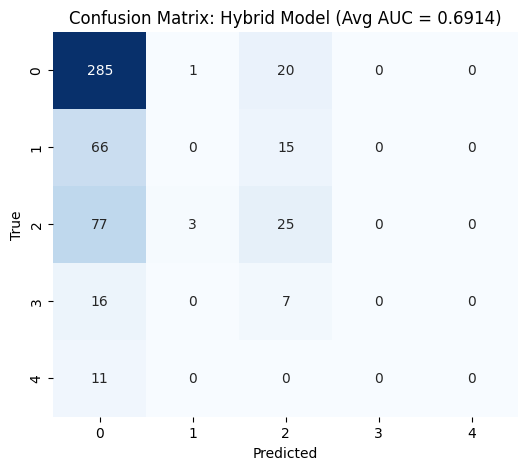

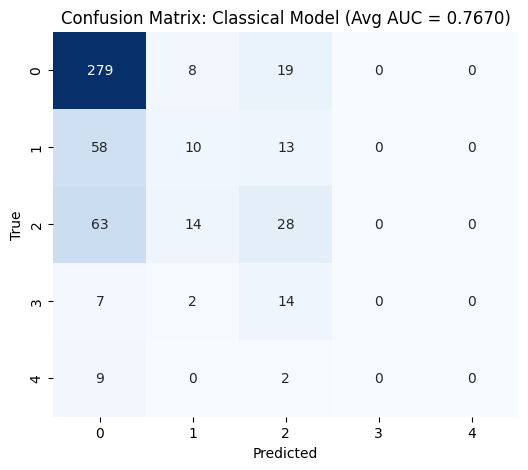

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)